In [1]:
import xarray as xr
import tarfile
import os
import pickle
import numpy as np
from scipy.interpolate import griddata
import 

In [3]:
def extractBounds(filename):
    dataset = xr.open_dataset(filename)
    pp = dataset.geospatial_bounds[9:-2].split(",")
    polygon = []
    center = np.array([0, 0])
    for point in pp:
        pt = np.array(list(map(float, point.split(" "))))
        polygon.append(pt)
        center = center + pt
    np_poly = np.array(polygon)
    
    return {"bounds": np_poly, "time": dataset.time_coverage_start,
           "center": center / len(polygon)}


In [44]:
# Opening all the VIIRS AOD data from a day, then getting key aspects of the data.

metadata = {}
folder = "data/VIIRS-20200320/"
nested_tars = os.listdir(folder)

for tar_nest in nested_tars:
    if (tar_nest == "metadata" or tar_nest == "merra.nc"):
        continue
    print("Extracting nested tar " + tar_nest)
    big_tar = tarfile.open(folder + tar_nest)
    big_tar.extractall(path="data/nested_tars")
    big_tar.close()
    
    
    tar_files = os.listdir("data/nested_tars")
    
    for tar_f in tar_files:
        print("Extracting " + tar_f)
        tar = tarfile.open("data/nested_tars/" + tar_f)
        tar.extractall(path="data/curr_data")
        tar.close()
        
        files = os.listdir("data/curr_data")
        for f in files:
            print("Opening " + f)
            
            ## THIS IS WHERE YOU CAN APPLY SOME SORT OF PROCESSING STEP TO ALL THE DATA
            metadata[tar_nest + "/" + tar_f + "/" + f] = extractBounds("data/curr_data/" + f)
            
            print("Deleting " + f)
            os.remove("data/curr_data/" + f)
            
        os.remove("data/nested_tars/" + tar_f)
    print("DONE WITH NESTED TAR \n\n")
        
print("Done")


with open(folder + "metadata", "wb") as handle:
    pickle.dump(metadata, handle)

NameError: name 'tar_next' is not defined

In [6]:
# Plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plotPolygon(ax, polygon, color, linewidth=2):
    for i in range(1, len(polygon)):
        ax.plot([polygon[i - 1][0], polygon[i][0]],
                [polygon[i - 1][1], polygon[i][1]],
                color=color, linewidth=linewidth,
               transform = ccrs.Geodetic())

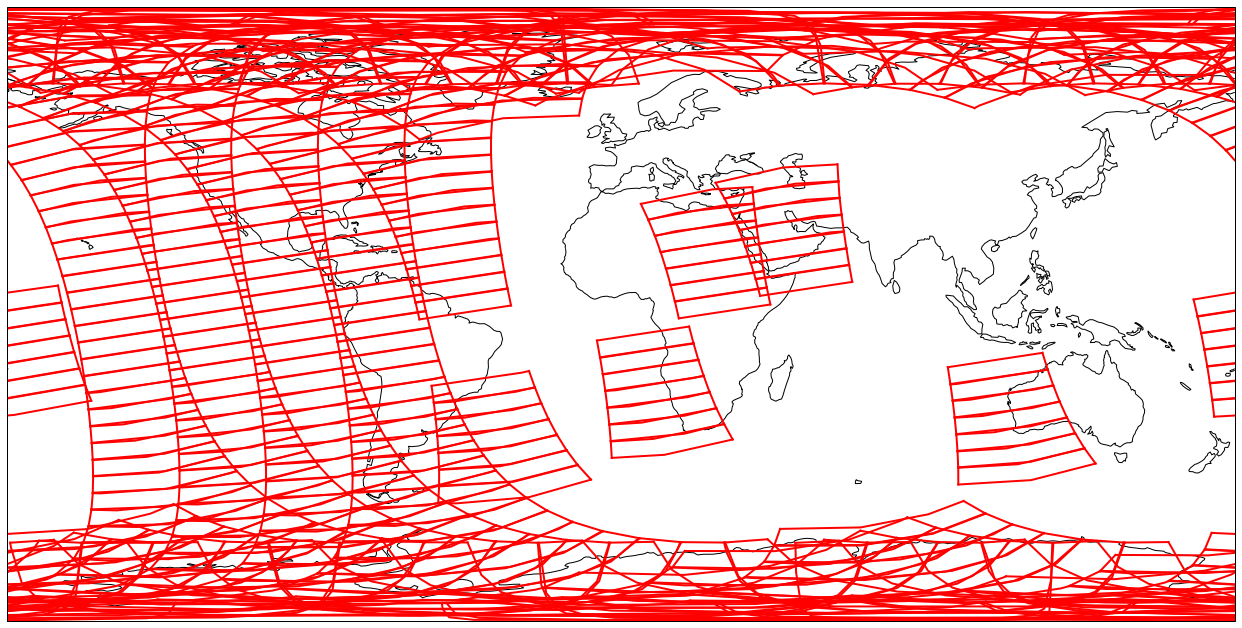

In [79]:
# test of polygon plotting by displaying all ROIs
fig, ax = plt.subplots(ncols=1, nrows=1, subplot_kw={'projection': ccrs.PlateCarree()})

for key in metadata:
    plotPolygon(ax, metadata[key]["bounds"], "red")
    
fig.set_size_inches(22, 16)
ax.coastlines()
plt.show()

In [29]:
## Given a point in (longitude, latitude) coords and returns nearest VIIRS file
def getVIIRSFile(point, metadata):
        m_files = np.array(list(metadata.keys()))
        m_vals = np.array(list(metadata.values()))
        c_points = []
        for vals in m_vals:
            c_points.append(vals["center"])
        # Gets closest point
        c_array = np.asarray(c_points)
        dists = np.sum((c_array - point)**2, axis=1)
        return [m_files[np.argmin(dists)], dists]

def retrieveVIIRSData(folder, filename):
    levels = filename.split("/")
    
    print("Extracting " + levels[0])
    big_tar = tarfile.open(folder + levels[0])
    big_tar.extractall(path="data/nested_tars")
    big_tar.close()
    
    print("Extracting " + levels[1] + " from " + levels[0])
    tar = tarfile.open("data/nested_tars/" + levels[1])
    tar.extractall(path="data/curr_data")
    tar.close()
    
    for tar_f in os.listdir("data/nested_tars/"):
        os.remove("data/nested_tars/" + tar_f)
    
    print("Reading " + levels[2])
    data = xr.open_dataset("data/curr_data/" + levels[2])
    
    for f in os.listdir("data/curr_data/"):
        os.remove("data/curr_data/" + f)
    
    return data
    
    
    
        
## Testing the functionality of getVIIRSFile
directory = "data/VIIRS-20200320/"
metadata = None

with open(directory + "metadata", "rb") as handle:
    metadata = pickle.load(handle)
[cal_name, cal_dist] = getVIIRSFile(np.array([-121.777888, 38.544647]), metadata)
cal_data = retrieveVIIRSData(directory, cal_name)


Extracting JPSS-GRAN_VIIRS-Aerosol-Optical-Depth-and-Aerosol-Particle-Size-EDRs_20200320_19245.tar
Extracting JRR-AOD_v2r1_j01_s202003202141057_e202003202151029_c202003202217020.tar.gz from JPSS-GRAN_VIIRS-Aerosol-Optical-Depth-and-Aerosol-Particle-Size-EDRs_20200320_19245.tar
Reading JRR-AOD_v2r1_j01_s202003202142314_e202003202143560_c202003202210570.nc


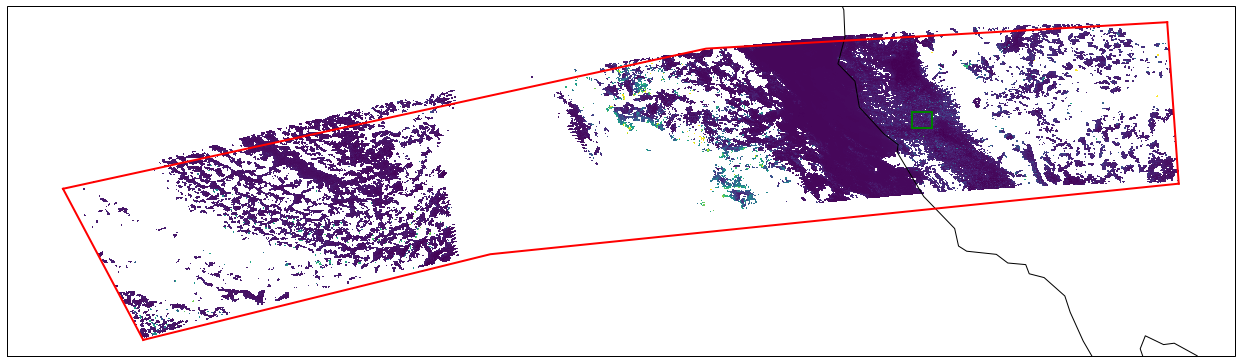

In [11]:


# Used to get ROI of VIIRS data around MERRA point
def getROI(lon, lat):
    d_lon = 0.625
    d_lat = 0.5
    polygon = []
    bounds = {"minLon": lon - (d_lon / 2), "maxLon": lon + (d_lon / 2),
              "minLat": lat - (d_lat / 2), "maxLat": lat + (d_lat / 2)}
    polygon.append(np.array([bounds["minLon"], bounds["minLat"]]))
    polygon.append(np.array([bounds["minLon"], bounds["maxLat"]]))
    polygon.append(np.array([bounds["maxLon"], bounds["maxLat"]]))
    polygon.append(np.array([bounds["maxLon"], bounds["minLat"]]))
    polygon.append(np.array([bounds["minLon"], bounds["minLat"]]))
    return [np.array(polygon), bounds]

fig, ax = plt.subplots(ncols=1, nrows=1, subplot_kw={'projection': ccrs.PlateCarree()})

plotPolygon(ax, metadata[cal_name]["bounds"], "red")
ax.pcolormesh(cal_data.Longitude.values, cal_data.Latitude.values, 
              cal_data.AOD550.values, transform=ccrs.PlateCarree())

cal_roi = getROI(-121.777888, 38.544647)
plotPolygon(ax, cal_roi[0], "green")

fig.set_size_inches(22, 16)
ax.coastlines()
plt.show()

In [12]:
# Gets the time of the swath's reading
def getT(m_data, swath_name):
    time = list(map(int, m_data[swath_name]["time"].split("T")[1][:-1].split(":")))
    if time[1] > 30:
        return time[0] + 1
    else:
        return time[0]

getT(metadata, cal_name)

22

In [61]:



def getGrid(boundary):
    numLonPoints = 50j
    numLatPoints = 40j
    return np.mgrid[boundary["minLon"]:boundary["maxLon"]:numLonPoints, 
                    boundary["minLat"]:boundary["maxLat"]:numLatPoints]

def gridVIIRS(s_points, data_array, boundary):
    numLonPoints = 50j
    numLatPoints = 40j
    
    lon_grid, lat_grid = np.mgrid[boundary["minLon"]:boundary["maxLon"]:numLonPoints, 
                                  boundary["minLat"]:boundary["maxLat"]:numLatPoints]
    
    
    grid = griddata(s_points, data_array, (lon_grid, lat_grid), method="nearest")
    return grid
    

In [14]:
[sample_points, aod_array] = getVIIRSArrays(cal_data)


0.0
0.0013020833333333333
0.0026041666666666665
0.00390625
0.005208333333333333
0.006510416666666667
0.0078125
0.009114583333333334
0.010416666666666666
0.01171875
0.013020833333333334
0.014322916666666666
0.015625
0.016927083333333332
0.018229166666666668
0.01953125
0.020833333333333332
0.022135416666666668
0.0234375
0.024739583333333332
0.026041666666666668
0.02734375
0.028645833333333332
0.029947916666666668
0.03125
0.032552083333333336
0.033854166666666664
0.03515625
0.036458333333333336
0.037760416666666664
0.0390625
0.040364583333333336
0.041666666666666664
0.04296875
0.044270833333333336
0.045572916666666664
0.046875
0.048177083333333336
0.049479166666666664
0.05078125
0.052083333333333336
0.053385416666666664
0.0546875
0.055989583333333336
0.057291666666666664
0.05859375
0.059895833333333336
0.061197916666666664
0.0625
0.06380208333333333
0.06510416666666667
0.06640625
0.06770833333333333
0.06901041666666667
0.0703125
0.07161458333333333
0.07291666666666667
0.07421875
0.0755208

0.6549479166666666
0.65625
0.6575520833333334
0.6588541666666666
0.66015625
0.6614583333333334
0.6627604166666666
0.6640625
0.6653645833333334
0.6666666666666666
0.66796875
0.6692708333333334
0.6705729166666666
0.671875
0.6731770833333334
0.6744791666666666
0.67578125
0.6770833333333334
0.6783854166666666
0.6796875
0.6809895833333334
0.6822916666666666
0.68359375
0.6848958333333334
0.6861979166666666
0.6875
0.6888020833333334
0.6901041666666666
0.69140625
0.6927083333333334
0.6940104166666666
0.6953125
0.6966145833333334
0.6979166666666666
0.69921875
0.7005208333333334
0.7018229166666666
0.703125
0.7044270833333334
0.7057291666666666
0.70703125
0.7083333333333334
0.7096354166666666
0.7109375
0.7122395833333334
0.7135416666666666
0.71484375
0.7161458333333334
0.7174479166666666
0.71875
0.7200520833333334
0.7213541666666666
0.72265625
0.7239583333333334
0.7252604166666666
0.7265625
0.7278645833333334
0.7291666666666666
0.73046875
0.7317708333333334
0.7330729166666666
0.734375
0.735677083

989


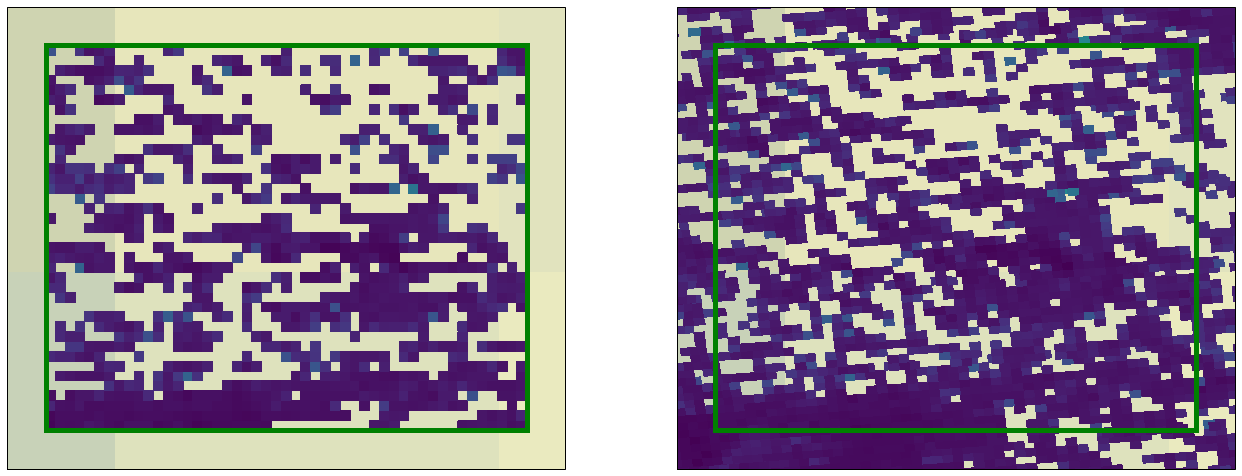

In [84]:

test_grid = gridVIIRS(sample_points, aod_array, cal_roi[1])
fig, axes = plt.subplots(ncols=2, nrows=1, subplot_kw={'projection': ccrs.PlateCarree()})

[lon_grid, lat_grid] = getGrid(cal_roi[1])


fig.set_size_inches(22, 16)

for ax in axes:
    ax.stock_img()

    ax.set_xlim([lon_grid.min() - 0.05, lon_grid.max() + 0.05])
    ax.set_ylim([lat_grid.min() - 0.05, lat_grid.max() + 0.05])
    
    plotPolygon(ax, cal_roi[0], "green", linewidth=5)


test = cal_data.AOD550.fillna(0)
vmax = test.values.max()
vmin = test.values.min()

np.count_nonzero(np.isnan())
axes[0].pcolormesh(lon_grid, lat_grid, test_grid, transform=ccrs.PlateCarree(), vmax=vmax, vmin=vmin)
axes[1].pcolormesh(cal_data.Longitude.values, cal_data.Latitude.values, cal_data.AOD550.values,transform=ccrs.PlateCarree(), vmax=vmax, vmin=vmin)
plt.show()

In [85]:
np.count_nonzero(np.isnan(test_grid))

989

### Below is the main conditioning program. 

#### Steps:

1. Get VIIRS bounding boxes

2. For each MERRA datapoint:
    1. Get distance from closest VIIRS bounding box - throw out ones that are too far (dist > 40)
        1. If the closest box has changed, then read new VIIRS data, and keep track of closest box
    2. Store value of datapoint
    3. getROI of datapoint
    4. gridVIIRS of datapoint - if it's too sparse (i.e. num nonzero > 80%)
    5. Save gridded VIIRS data, metadata of MERRA datapoint
    

In [45]:
merra_data = xr.open_dataset("data/VIIRS-20200320/merra.nc")

In [59]:
print(merra_data)
for x in range(len(merra_data.lon)):
    for y in range(len(merra_data.lat)):
        print(merra_data.lon.values[x], merra_data.lat.values[y], merra_data.TOTEXTTAU.values[0][x][y])

<xarray.Dataset>
Dimensions:    (lat: 361, lon: 576, time: 24)
Coordinates:
  * lon        (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat        (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * time       (time) datetime64[ns] 2020-03-20T00:30:00 ... 2020-03-20T23:30:00
Data variables:
    BCANGSTR   (time, lat, lon) float32 ...
    BCCMASS    (time, lat, lon) float32 ...
    BCEXTTAU   (time, lat, lon) float32 ...
    BCFLUXU    (time, lat, lon) float32 ...
    BCFLUXV    (time, lat, lon) float32 ...
    BCSCATAU   (time, lat, lon) float32 ...
    BCSMASS    (time, lat, lon) float32 ...
    DMSCMASS   (time, lat, lon) float32 ...
    DMSSMASS   (time, lat, lon) float32 ...
    DUANGSTR   (time, lat, lon) float32 ...
    DUCMASS    (time, lat, lon) float32 ...
    DUCMASS25  (time, lat, lon) float32 ...
    DUEXTT25   (time, lat, lon) float32 ...
    DUEXTTAU   (time, lat, lon) float32 ...
    DUFLUXU    (time, lat, lon) float32 ...
    DUFLUXV

-180.0 40.5 0.03506105
-180.0 41.0 0.03506105
-180.0 41.5 0.03506105
-180.0 42.0 0.03506105
-180.0 42.5 0.03506105
-180.0 43.0 0.03506105
-180.0 43.5 0.03506105
-180.0 44.0 0.03506105
-180.0 44.5 0.03506105
-180.0 45.0 0.03506105
-180.0 45.5 0.03506105
-180.0 46.0 0.034015823
-180.0 46.5 0.033100296
-180.0 47.0 0.033100296
-180.0 47.5 0.033100296
-180.0 48.0 0.033100296
-180.0 48.5 0.033100296
-180.0 49.0 0.033100296
-180.0 49.5 0.033100296
-180.0 50.0 0.033100296
-180.0 50.5 0.033100296
-180.0 51.0 0.033100296
-180.0 51.5 0.033100296
-180.0 52.0 0.033100296
-180.0 52.5 0.033100296
-180.0 53.0 0.033100296
-180.0 53.5 0.033100296
-180.0 54.0 0.033100296
-180.0 54.5 0.033100296
-180.0 55.0 0.033100296
-180.0 55.5 0.033100296
-180.0 56.0 0.033100296
-180.0 56.5 0.033100296
-180.0 57.0 0.033100296
-180.0 57.5 0.033100296
-180.0 58.0 0.033100296
-180.0 58.5 0.033100296
-180.0 59.0 0.033100296
-180.0 59.5 0.033100296
-180.0 60.0 0.033100296
-180.0 60.5 0.033100296
-180.0 61.0 0.033100296
-18

-179.375 83.0 0.033100296
-179.375 83.5 0.033100296
-179.375 84.0 0.033100296
-179.375 84.5 0.033100296
-179.375 85.0 0.033100296
-179.375 85.5 0.032970596
-179.375 86.0 0.03277986
-179.375 86.5 0.03277986
-179.375 87.0 0.03277986
-179.375 87.5 0.03277986
-179.375 88.0 0.03277986
-179.375 88.5 0.03277986
-179.375 89.0 0.032589126
-179.375 89.5 0.032467056
-179.375 90.0 0.032467056
-178.75 -90.0 0.029926466
-178.75 -89.5 0.029926466
-178.75 -89.0 0.029926466
-178.75 -88.5 0.029926466
-178.75 -88.0 0.029926466
-178.75 -87.5 0.029926466
-178.75 -87.0 0.029926466
-178.75 -86.5 0.029926466
-178.75 -86.0 0.030285047
-178.75 -85.5 0.030307936
-178.75 -85.0 0.030307936
-178.75 -84.5 0.030307936
-178.75 -84.0 0.030307936
-178.75 -83.5 0.030307936
-178.75 -83.0 0.030307936
-178.75 -82.5 0.030307936
-178.75 -82.0 0.030307936
-178.75 -81.5 0.030307936
-178.75 -81.0 0.030643629
-178.75 -80.5 0.030697035
-178.75 -80.0 0.030697035
-178.75 -79.5 0.030697035
-178.75 -79.0 0.030697035
-178.75 -78.5 0.03

-178.125 -1.0 0.04147737
-178.125 -0.5 0.04147737
-178.125 -1.7975103014118005e-13 0.041279007
-178.125 0.5 0.041172195
-178.125 1.0 0.041172195
-178.125 1.5 0.041172195
-178.125 2.0 0.041050125
-178.125 2.5 0.04086702
-178.125 3.0 0.04086702
-178.125 3.5 0.04086702
-178.125 4.0 0.040668655
-178.125 4.5 0.040546585
-178.125 5.0 0.040546585
-178.125 5.5 0.04047029
-178.125 6.0 0.040058304
-178.125 6.5 0.040012527
-178.125 7.0 0.039814163
-178.125 7.5 0.03949373
-178.125 8.0 0.03934114
-178.125 8.5 0.039188553
-178.125 9.0 0.0388376
-178.125 9.5 0.038776565
-178.125 10.0 0.03848665
-178.125 10.5 0.038425613
-178.125 11.0 0.03834932
-178.125 11.5 0.038257767
-178.125 12.0 0.03821199
-178.125 12.5 0.03807466
-178.125 13.0 0.038059402
-178.125 13.5 0.037906814
-178.125 14.0 0.03784578
-178.125 14.5 0.03772371
-178.125 15.0 0.03772371
-178.125 15.5 0.03772371
-178.125 16.0 0.03772371
-178.125 16.5 0.037738968
-178.125 17.0 0.037738968
-178.125 17.5 0.037738968
-178.125 18.0 0.037738968
-178.

-177.5 68.0 0.029667066
-177.5 68.5 0.029667066
-177.5 69.0 0.029651808
-177.5 69.5 0.029636549
-177.5 70.0 0.029560255
-177.5 70.5 0.029476332
-177.5 71.0 0.02936952
-177.5 71.5 0.029293226
-177.5 72.0 0.02923219
-177.5 72.5 0.029140638
-177.5 73.0 0.029079603
-177.5 73.5 0.02898042
-177.5 74.0 0.02885835
-177.5 74.5 0.028804945
-177.5 75.0 0.028721021
-177.5 75.5 0.02861421
-177.5 76.0 0.028568434
-177.5 76.5 0.028446363
-177.5 77.0 0.028400587
-177.5 77.5 0.028316664
-177.5 78.0 0.028301405
-177.5 78.5 0.028270887
-177.5 79.0 0.028247999
-177.5 79.5 0.028209852
-177.5 80.0 0.028194593
-177.5 80.5 0.028194593
-177.5 81.0 0.028194593
-177.5 81.5 0.028194593
-177.5 82.0 0.028194593
-177.5 82.5 0.028194593
-177.5 83.0 0.028194593
-177.5 83.5 0.028194593
-177.5 84.0 0.028194593
-177.5 84.5 0.028148817
-177.5 85.0 0.028087782
-177.5 85.5 0.028042005
-177.5 86.0 0.02798097
-177.5 86.5 0.027950453
-177.5 87.0 0.027897047
-177.5 87.5 0.027897047
-177.5 88.0 0.027820753
-177.5 88.5 0.02782838

-176.875 54.5 0.0301172
-176.875 55.0 0.0301172
-176.875 55.5 0.029987501
-176.875 56.0 0.02975099
-176.875 56.5 0.029560255
-176.875 57.0 0.02936952
-176.875 57.5 0.029209303
-176.875 58.0 0.029201673
-176.875 58.5 0.029201673
-176.875 59.0 0.029201673
-176.875 59.5 0.02924745
-176.875 60.0 0.02924745
-176.875 60.5 0.02924745
-176.875 61.0 0.02924745
-176.875 61.5 0.02924745
-176.875 62.0 0.029293226
-176.875 62.5 0.029293226
-176.875 63.0 0.029293226
-176.875 63.5 0.029293226
-176.875 64.0 0.029331373
-176.875 64.5 0.029339002
-176.875 65.0 0.029346632
-176.875 65.5 0.02937715
-176.875 66.0 0.029445814
-176.875 66.5 0.029468702
-176.875 67.0 0.02949159
-176.875 67.5 0.029445814
-176.875 68.0 0.029346632
-176.875 68.5 0.029262709
-176.875 69.0 0.029140638
-176.875 69.5 0.029064344
-176.875 70.0 0.029033827
-176.875 70.5 0.02900331
-176.875 71.0 0.02900331
-176.875 71.5 0.028965162
-176.875 72.0 0.028949903
-176.875 72.5 0.028927015
-176.875 73.0 0.028904127
-176.875 73.5 0.028881239
-

-176.25 49.5 0.029468702
-176.25 50.0 0.029468702
-176.25 50.5 0.029468702
-176.25 51.0 0.029468702
-176.25 51.5 0.029468702
-176.25 52.0 0.029468702
-176.25 52.5 0.029468702
-176.25 53.0 0.029468702
-176.25 53.5 0.029468702
-176.25 54.0 0.029346632
-176.25 54.5 0.02899568
-176.25 55.0 0.028675245
-176.25 55.5 0.028522657
-176.25 56.0 0.028522657
-176.25 56.5 0.028522657
-176.25 57.0 0.028530287
-176.25 57.5 0.028583692
-176.25 58.0 0.028583692
-176.25 58.5 0.028583692
-176.25 59.0 0.028583692
-176.25 59.5 0.02860658
-176.25 60.0 0.028644728
-176.25 60.5 0.028644728
-176.25 61.0 0.028644728
-176.25 61.5 0.028667616
-176.25 62.0 0.02873628
-176.25 62.5 0.028850721
-176.25 63.0 0.028965162
-176.25 63.5 0.029102491
-176.25 64.0 0.029133009
-176.25 64.5 0.029163526
-176.25 65.0 0.029209303
-176.25 65.5 0.029216932
-176.25 66.0 0.029216932
-176.25 66.5 0.02924745
-176.25 67.0 0.02924745
-176.25 67.5 0.02925508
-176.25 68.0 0.029270338
-176.25 68.5 0.029277967
-176.25 69.0 0.029300855
-176.2

-175.0 -70.5 0.026333021
-175.0 -70.0 0.02534883
-175.0 -69.5 0.024471449
-175.0 -69.0 0.023533033
-175.0 -68.5 0.023296522
-175.0 -68.0 0.023037123
-175.0 -67.5 0.022747206
-175.0 -67.0 0.022525953
-175.0 -66.5 0.022525953
-175.0 -66.0 0.022525953
-175.0 -65.5 0.022510694
-175.0 -65.0 0.022373365
-175.0 -64.5 0.022236036
-175.0 -64.0 0.022083448
-175.0 -63.5 0.021724867
-175.0 -63.0 0.021351026
-175.0 -62.5 0.021000074
-175.0 -62.0 0.020687269
-175.0 -61.5 0.021198438
-175.0 -61.0 0.021724867
-175.0 -60.5 0.022243666
-175.0 -60.0 0.022792982
-175.0 -59.5 0.023037123
-175.0 -59.0 0.023273634
-175.0 -58.5 0.023525404
-175.0 -58.0 0.023533033
-175.0 -57.5 0.023533033
-175.0 -57.0 0.023533033
-175.0 -56.5 0.023342298
-175.0 -56.0 0.023105787
-175.0 -55.5 0.022899793
-175.0 -55.0 0.022724317
-175.0 -54.5 0.022854017
-175.0 -54.0 0.023006605
-175.0 -53.5 0.023304151
-175.0 -53.0 0.02356355
-175.0 -52.5 0.022884535
-175.0 -52.0 0.022373365
-175.0 -51.5 0.021877455
-175.0 -51.0 0.021129774
-1

-174.375 -32.0 0.034023453
-174.375 -31.5 0.042560745
-174.375 -31.0 0.04602449
-174.375 -30.5 0.04602449
-174.375 -30.0 0.04602449
-174.375 -29.5 0.04602449
-174.375 -29.0 0.04600923
-174.375 -28.5 0.045978714
-174.375 -28.0 0.045978714
-174.375 -27.5 0.045978714
-174.375 -27.0 0.045978714
-174.375 -26.5 0.045978714
-174.375 -26.0 0.04791658
-174.375 -25.5 0.049610306
-174.375 -25.0 0.049610306
-174.375 -24.5 0.049610306
-174.375 -24.0 0.049610306
-174.375 -23.5 0.049610306
-174.375 -23.0 0.049595047
-174.375 -22.5 0.049595047
-174.375 -22.0 0.049595047
-174.375 -21.5 0.049595047
-174.375 -21.0 0.049595047
-174.375 -20.5 0.048359085
-174.375 -20.0 0.046436477
-174.375 -19.5 0.046314407
-174.375 -19.0 0.046436477
-174.375 -18.5 0.046482254
-174.375 -18.0 0.046482254
-174.375 -17.5 0.046482254
-174.375 -17.0 0.046482254
-174.375 -16.5 0.0466501
-174.375 -16.0 0.04666536
-174.375 -15.5 0.04666536
-174.375 -15.0 0.047886062
-174.375 -14.5 0.04941194
-174.375 -14.0 0.05017488
-174.375 -13.

-173.75 -15.0 0.050861526
-173.75 -14.5 0.050876785
-173.75 -14.0 0.05095308
-173.75 -13.5 0.05095308
-173.75 -13.0 0.050983597
-173.75 -12.5 0.051029373
-173.75 -12.0 0.051029373
-173.75 -11.5 0.051105667
-173.75 -11.0 0.052143265
-173.75 -10.5 0.053791214
-173.75 -10.0 0.055271316
-173.75 -9.5 0.05623262
-173.75 -9.0 0.05623262
-173.75 -8.5 0.056308914
-173.75 -8.0 0.05635469
-173.75 -7.5 0.056430984
-173.75 -7.0 0.05649202
-173.75 -6.5 0.05659883
-173.75 -6.0 0.056446243
-173.75 -5.5 0.055912185
-173.75 -5.0 0.055286575
-173.75 -4.5 0.05408113
-173.75 -4.0 0.05221956
-173.75 -3.5 0.051471878
-173.75 -3.0 0.051288772
-173.75 -2.5 0.051014114
-173.75 -2.0 0.05080049
-173.75 -1.5 0.05057161
-173.75 -1.0 0.050357986
-173.75 -0.5 0.049854446
-173.75 -1.7975103014118005e-13 0.049152542
-173.75 0.5 0.048649002
-173.75 1.0 0.04816072
-173.75 1.5 0.047702957
-173.75 2.0 0.04727571
-173.75 2.5 0.046878982
-173.75 3.0 0.046695877
-173.75 3.5 0.04654329
-173.75 4.0 0.046375442
-173.75 4.5 0.046

-173.125 -29.0 0.04033296
-173.125 -28.5 0.04033296
-173.125 -28.0 0.04033296
-173.125 -27.5 0.04033296
-173.125 -27.0 0.04033296
-173.125 -26.5 0.04033296
-173.125 -26.0 0.04339998
-173.125 -25.5 0.046100784
-173.125 -25.0 0.046100784
-173.125 -24.5 0.046100784
-173.125 -24.0 0.046100784
-173.125 -23.5 0.046100784
-173.125 -23.0 0.046100784
-173.125 -22.5 0.046100784
-173.125 -22.0 0.046100784
-173.125 -21.5 0.046497513
-173.125 -21.0 0.046466995
-173.125 -20.5 0.046466995
-173.125 -20.0 0.046466995
-173.125 -19.5 0.046466995
-173.125 -19.0 0.046466995
-173.125 -18.5 0.046375442
-173.125 -18.0 0.046344925
-173.125 -17.5 0.046344925
-173.125 -17.0 0.046848465
-173.125 -16.5 0.049106766
-173.125 -16.0 0.049991775
-173.125 -15.5 0.049991775
-173.125 -15.0 0.050083328
-173.125 -14.5 0.050083328
-173.125 -14.0 0.050113846
-173.125 -13.5 0.05017488
-173.125 -13.0 0.05017488
-173.125 -12.5 0.050647903
-173.125 -12.0 0.05234163
-173.125 -11.5 0.053898025
-173.125 -11.0 0.054508377
-173.125 -1

-172.5 -47.0 0.01890199
-172.5 -46.5 0.018863844
-172.5 -46.0 0.018860029
-172.5 -45.5 0.018856214
-172.5 -45.0 0.0188524
-172.5 -44.5 0.018848585
-172.5 -44.0 0.018806623
-172.5 -43.5 0.018623518
-172.5 -43.0 0.01847856
-172.5 -42.5 0.018360304
-172.5 -42.0 0.018364118
-172.5 -41.5 0.018364118
-172.5 -41.0 0.018375563
-172.5 -40.5 0.018375563
-172.5 -40.0 0.018387007
-172.5 -39.5 0.018436598
-172.5 -39.0 0.018894361
-172.5 -38.5 0.01954286
-172.5 -38.0 0.019809889
-172.5 -37.5 0.019809889
-172.5 -37.0 0.019809889
-172.5 -36.5 0.019809889
-172.5 -36.0 0.019760298
-172.5 -35.5 0.019699262
-172.5 -35.0 0.019840406
-172.5 -34.5 0.022899793
-172.5 -34.0 0.025768446
-172.5 -33.5 0.025814222
-172.5 -33.0 0.025814222
-172.5 -32.5 0.025638746
-172.5 -32.0 0.025524305
-172.5 -31.5 0.025524305
-172.5 -31.0 0.025524305
-172.5 -30.5 0.026424574
-172.5 -30.0 0.03533571
-172.5 -29.5 0.035892654
-172.5 -29.0 0.035892654
-172.5 -28.5 0.035892654
-172.5 -28.0 0.035892654
-172.5 -27.5 0.035892654
-172.5

-171.875 -7.0 0.048771072
-171.875 -6.5 0.0489084
-171.875 -6.0 0.048740555
-171.875 -5.5 0.048511673
-171.875 -5.0 0.048328567
-171.875 -4.5 0.04831331
-171.875 -4.0 0.04831331
-171.875 -3.5 0.04842012
-171.875 -3.0 0.048603225
-171.875 -2.5 0.048725296
-171.875 -2.0 0.048343826
-171.875 -1.5 0.047962356
-171.875 -1.0 0.047840286
-171.875 -0.5 0.047947098
-171.875 -1.7975103014118005e-13 0.048267532
-171.875 0.5 0.04867952
-171.875 1.0 0.049076248
-171.875 1.5 0.049488235
-171.875 2.0 0.049869705
-171.875 2.5 0.04980867
-171.875 3.0 0.04967134
-171.875 3.5 0.04954927
-171.875 4.0 0.049152542
-171.875 4.5 0.048267532
-171.875 5.0 0.047382522
-171.875 5.5 0.046558548
-171.875 6.0 0.04576509
-171.875 6.5 0.04475801
-171.875 7.0 0.04311006
-171.875 7.5 0.04111116
-171.875 8.0 0.03960054
-171.875 8.5 0.038654495
-171.875 9.0 0.037937332
-171.875 9.5 0.037128616
-171.875 10.0 0.0365793
-171.875 10.5 0.036609817
-171.875 11.0 0.036747146
-171.875 11.5 0.036884475
-171.875 12.0 0.037021805
-1

-171.25 79.5 0.025493788
-171.25 80.0 0.025486158
-171.25 80.5 0.025371717
-171.25 81.0 0.02521913
-171.25 81.5 0.025066542
-171.25 82.0 0.024906324
-171.25 82.5 0.024746107
-171.25 83.0 0.02458589
-171.25 83.5 0.02444856
-171.25 84.0 0.024440931
-171.25 84.5 0.024440931
-171.25 85.0 0.024440931
-171.25 85.5 0.024387525
-171.25 86.0 0.024219679
-171.25 86.5 0.024036573
-171.25 87.0 0.023853468
-171.25 87.5 0.023800062
-171.25 88.0 0.023792433
-171.25 88.5 0.02382295
-171.25 89.0 0.023845838
-171.25 89.5 0.023868727
-171.25 90.0 0.023899244
-170.625 -90.0 0.025135206
-170.625 -89.5 0.02507417
-170.625 -89.0 0.024913954
-170.625 -88.5 0.024913954
-170.625 -88.0 0.025524305
-170.625 -87.5 0.026935743
-170.625 -87.0 0.026806043
-170.625 -86.5 0.026577162
-170.625 -86.0 0.026371168
-170.625 -85.5 0.026142286
-170.625 -85.0 0.025882887
-170.625 -84.5 0.026233839
-170.625 -84.0 0.026386427
-170.625 -83.5 0.026333021
-170.625 -83.0 0.02597444
-170.625 -82.5 0.025570082
-170.625 -82.0 0.0253030

-170.625 81.5 0.02546327
-170.625 82.0 0.025402235
-170.625 82.5 0.025371717
-170.625 83.0 0.025295423
-170.625 83.5 0.025188612
-170.625 84.0 0.02495973
-170.625 84.5 0.024730848
-170.625 85.0 0.024532484
-170.625 85.5 0.02433412
-170.625 86.0 0.024158644
-170.625 86.5 0.024112867
-170.625 87.0 0.024112867
-170.625 87.5 0.02407472
-170.625 88.0 0.023998426
-170.625 88.5 0.023891615
-170.625 89.0 0.023784803
-170.625 89.5 0.02370088
-170.625 90.0 0.023632215
-170.0 -90.0 0.030651258
-170.0 -89.5 0.030315565
-170.0 -89.0 0.030315565
-170.0 -88.5 0.030636
-170.0 -88.0 0.03176515
-170.0 -87.5 0.03153627
-170.0 -87.0 0.031368423
-170.0 -86.5 0.031109022
-170.0 -86.0 0.030933546
-170.0 -85.5 0.030582594
-170.0 -85.0 0.030994581
-170.0 -84.5 0.031093763
-170.0 -84.0 0.030933546
-170.0 -83.5 0.0307657
-170.0 -83.0 0.030483412
-170.0 -82.5 0.030208753
-170.0 -82.0 0.029384779
-170.0 -81.5 0.028591322
-170.0 -81.0 0.028400587
-170.0 -80.5 0.028400587
-170.0 -80.0 0.028293775
-170.0 -79.5 0.0281

-169.375 -73.0 0.026195692
-169.375 -72.5 0.025982069
-169.375 -72.0 0.025692152
-169.375 -71.5 0.025386976
-169.375 -71.0 0.025051283
-169.375 -70.5 0.024654554
-169.375 -70.0 0.023853468
-169.375 -69.5 0.023212599
-169.375 -69.0 0.022640394
-169.375 -68.5 0.021961378
-169.375 -68.0 0.021404432
-169.375 -67.5 0.020954298
-169.375 -67.0 0.020466017
-169.375 -66.5 0.020057844
-169.375 -66.0 0.019592451
-169.375 -65.5 0.018943952
-169.375 -65.0 0.018669294
-169.375 -64.5 0.018684553
-169.375 -64.0 0.018684553
-169.375 -63.5 0.018676924
-169.375 -63.0 0.018707441
-169.375 -62.5 0.019069837
-169.375 -62.0 0.019462751
-169.375 -61.5 0.019699262
-169.375 -61.0 0.019886183
-169.375 -60.5 0.02016847
-169.375 -60.0 0.020359205
-169.375 -59.5 0.020321058
-169.375 -59.0 0.020115064
-169.375 -58.5 0.019935774
-169.375 -58.0 0.019775556
-169.375 -57.5 0.019527601
-169.375 -57.0 0.019367384
-169.375 -56.5 0.019401716
-169.375 -56.0 0.019432234
-169.375 -55.5 0.01941316
-169.375 -55.0 0.019203352
-16

-169.375 85.5 0.02445619
-169.375 86.0 0.02406709
-169.375 86.5 0.023761915
-169.375 87.0 0.02357118
-169.375 87.5 0.023464369
-169.375 88.0 0.023365187
-169.375 88.5 0.023250746
-169.375 89.0 0.023113417
-169.375 89.5 0.023006605
-169.375 90.0 0.022869276
-168.75 -90.0 0.037174392
-168.75 -89.5 0.036289383
-168.75 -89.0 0.035984207
-168.75 -88.5 0.035877395
-168.75 -88.0 0.035785843
-168.75 -87.5 0.035663772
-168.75 -87.0 0.03532045
-168.75 -86.5 0.034511734
-168.75 -86.0 0.034359146
-168.75 -85.5 0.03430574
-168.75 -85.0 0.034259964
-168.75 -84.5 0.034221817
-168.75 -84.0 0.033840347
-168.75 -83.5 0.033016372
-168.75 -83.0 0.03277986
-168.75 -82.5 0.032695938
-168.75 -82.0 0.032596756
-168.75 -81.5 0.032459427
-168.75 -81.0 0.03176515
-168.75 -80.5 0.030788587
-168.75 -80.0 0.030323194
-168.75 -79.5 0.030201124
-168.75 -79.0 0.030071424
-168.75 -78.5 0.029926466
-168.75 -78.0 0.029438185
-168.75 -77.5 0.029194044
-168.75 -77.0 0.029033827
-168.75 -76.5 0.02900331
-168.75 -76.0 0.0290

-168.125 26.0 0.0365793
-168.125 26.5 0.035381485
-168.125 27.0 0.032383133
-168.125 27.5 0.030941175
-168.125 28.0 0.031070875
-168.125 28.5 0.031253982
-168.125 29.0 0.031437088
-168.125 29.5 0.030590223
-168.125 30.0 0.02810304
-168.125 30.5 0.027126478
-168.125 31.0 0.02722566
-168.125 31.5 0.027317213
-168.125 32.0 0.027401136
-168.125 32.5 0.026798414
-168.125 33.0 0.026073622
-168.125 33.5 0.026271986
-168.125 34.0 0.026554273
-168.125 34.5 0.027080702
-168.125 35.0 0.027073072
-168.125 35.5 0.025989698
-168.125 36.0 0.025867628
-168.125 36.5 0.026020216
-168.125 37.0 0.026363539
-168.125 37.5 0.026485609
-168.125 38.0 0.025394605
-168.125 38.5 0.02395265
-168.125 39.0 0.023975538
-168.125 39.5 0.024280714
-168.125 40.0 0.024280714
-168.125 40.5 0.023853468
-168.125 41.0 0.020839857
-168.125 41.5 0.020763563
-168.125 42.0 0.020763563
-168.125 42.5 0.020763563
-168.125 43.0 0.020778822
-168.125 43.5 0.019493269
-168.125 44.0 0.019195722
-168.125 44.5 0.019195722
-168.125 45.0 0.0

-167.5 12.0 0.04062288
-167.5 12.5 0.040958572
-167.5 13.0 0.041294266
-167.5 13.5 0.041416336
-167.5 14.0 0.04071443
-167.5 14.5 0.04011934
-167.5 15.0 0.039524246
-167.5 15.5 0.03895967
-167.5 16.0 0.038761307
-167.5 16.5 0.038807083
-167.5 17.0 0.038746048
-167.5 17.5 0.038379837
-167.5 18.0 0.038013626
-167.5 18.5 0.037540603
-167.5 19.0 0.0360605
-167.5 19.5 0.035541702
-167.5 20.0 0.035366226
-167.5 20.5 0.035404373
-167.5 21.0 0.035404373
-167.5 21.5 0.03544252
-167.5 22.0 0.03531282
-167.5 22.5 0.035030533
-167.5 23.0 0.03454225
-167.5 23.5 0.03454988
-167.5 24.0 0.034603287
-167.5 24.5 0.034725357
-167.5 25.0 0.035144974
-167.5 25.5 0.03519075
-167.5 26.0 0.03519075
-167.5 26.5 0.03519075
-167.5 27.0 0.035221267
-167.5 27.5 0.034977127
-167.5 28.0 0.033703018
-167.5 28.5 0.033703018
-167.5 29.0 0.034099746
-167.5 29.5 0.0344507
-167.5 30.0 0.034755874
-167.5 30.5 0.03342073
-167.5 31.0 0.031810928
-167.5 31.5 0.031864334
-167.5 32.0 0.032200027
-167.5 32.5 0.032604385
-167.5 3

-166.875 73.5 0.02168672
-166.875 74.0 0.021671461
-166.875 74.5 0.02156465
-166.875 75.0 0.021480726
-166.875 75.5 0.021526502
-166.875 76.0 0.021595167
-166.875 76.5 0.021579908
-166.875 77.0 0.021480726
-166.875 77.5 0.021320509
-166.875 78.0 0.02117555
-166.875 78.5 0.021152662
-166.875 79.0 0.02117555
-166.875 79.5 0.021259474
-166.875 80.0 0.02129762
-166.875 80.5 0.021373915
-166.875 81.0 0.021488355
-166.875 81.5 0.021610426
-166.875 82.0 0.021633314
-166.875 82.5 0.021625685
-166.875 83.0 0.021778272
-166.875 83.5 0.02205293
-166.875 84.0 0.022297071
-166.875 84.5 0.022533583
-166.875 85.0 0.022579359
-166.875 85.5 0.02257173
-166.875 86.0 0.022548841
-166.875 86.5 0.022350477
-166.875 87.0 0.022129225
-166.875 87.5 0.021907972
-166.875 88.0 0.021701979
-166.875 88.5 0.021518873
-166.875 89.0 0.021373915
-166.875 89.5 0.021145033
-166.875 90.0 0.020786451
-166.25 -90.0 0.03795259
-166.25 -89.5 0.03796785
-166.25 -89.0 0.036640335
-166.25 -88.5 0.03177278
-166.25 -88.0 0.031490

-165.625 -59.0 0.036167312
-165.625 -58.5 0.036487747
-165.625 -58.0 0.037372757
-165.625 -57.5 0.038059402
-165.625 -57.0 0.03873079
-165.625 -56.5 0.038868118
-165.625 -56.0 0.03873079
-165.625 -55.5 0.03845613
-165.625 -55.0 0.03821199
-165.625 -54.5 0.037235428
-165.625 -54.0 0.03504579
-165.625 -53.5 0.03357332
-165.625 -53.0 0.03280275
-165.625 -52.5 0.03280275
-165.625 -52.0 0.03268068
-165.625 -51.5 0.03100221
-165.625 -51.0 0.02887361
-165.625 -50.5 0.02785127
-165.625 -50.0 0.028057264
-165.625 -49.5 0.028293775
-165.625 -49.0 0.0278589
-165.625 -48.5 0.026897596
-165.625 -48.0 0.026241468
-165.625 -47.5 0.02685945
-165.625 -47.0 0.027568983
-165.625 -46.5 0.027660536
-165.625 -46.0 0.025859999
-165.625 -45.5 0.024608778
-165.625 -45.0 0.02471559
-165.625 -44.5 0.024791883
-165.625 -44.0 0.02395265
-165.625 -43.5 0.022602247
-165.625 -43.0 0.0224344
-165.625 -42.5 0.022426771
-165.625 -42.0 0.022419142
-165.625 -41.5 0.023021864
-165.625 -41.0 0.023746656
-165.625 -40.5 0.023

-165.0 -72.0 0.032375503
-165.0 -71.5 0.033497024
-165.0 -71.0 0.034504104
-165.0 -70.5 0.034778763
-165.0 -70.0 0.034893204
-165.0 -69.5 0.036289383
-165.0 -69.0 0.039676834
-165.0 -68.5 0.04298799
-165.0 -68.0 0.04500215
-165.0 -67.5 0.044361282
-165.0 -67.0 0.04373567
-165.0 -66.5 0.04373567
-165.0 -66.0 0.0471689
-165.0 -65.5 0.050785232
-165.0 -65.0 0.05145662
-165.0 -64.5 0.05080049
-165.0 -64.0 0.04689424
-165.0 -63.5 0.04272859
-165.0 -63.0 0.042316604
-165.0 -62.5 0.042530227
-165.0 -62.0 0.042530227
-165.0 -61.5 0.04237764
-165.0 -61.0 0.041279007
-165.0 -60.5 0.040149856
-165.0 -60.0 0.039570022
-165.0 -59.5 0.03911226
-165.0 -59.0 0.03897493
-165.0 -58.5 0.038944412
-165.0 -58.0 0.03847139
-165.0 -57.5 0.03781526
-165.0 -57.0 0.037113357
-165.0 -56.5 0.036411453
-165.0 -56.0 0.03583162
-165.0 -55.5 0.036121536
-165.0 -55.0 0.036518265
-165.0 -54.5 0.03630464
-165.0 -54.0 0.035656143
-165.0 -53.5 0.034900833
-165.0 -53.0 0.033611465
-165.0 -52.5 0.033222366
-165.0 -52.0 0.03

-164.375 -75.5 0.02872865
-164.375 -75.0 0.028515028
-164.375 -74.5 0.028804945
-164.375 -74.0 0.028850721
-164.375 -73.5 0.028850721
-164.375 -73.0 0.029483961
-164.375 -72.5 0.030773329
-164.375 -72.0 0.032077957
-164.375 -71.5 0.032642532
-164.375 -71.0 0.03344362
-164.375 -70.5 0.037540603
-164.375 -70.0 0.044315506
-164.375 -69.5 0.04869478
-164.375 -69.0 0.04878633
-164.375 -68.5 0.048099685
-164.375 -68.0 0.046695877
-164.375 -67.5 0.04603975
-164.375 -67.0 0.046070267
-164.375 -66.5 0.04591768
-164.375 -66.0 0.04579561
-164.375 -65.5 0.04538362
-164.375 -65.0 0.04552095
-164.375 -64.5 0.04300325
-164.375 -64.0 0.041462112
-164.375 -63.5 0.041034866
-164.375 -63.0 0.041904617
-164.375 -62.5 0.043293167
-164.375 -62.0 0.044208694
-164.375 -61.5 0.042148758
-164.375 -61.0 0.04010408
-164.375 -60.5 0.038883377
-164.375 -60.0 0.0383188
-164.375 -59.5 0.037677933
-164.375 -59.0 0.037021805
-164.375 -58.5 0.03618257
-164.375 -58.0 0.035846878
-164.375 -57.5 0.03570955
-164.375 -57.0 0

-163.75 -60.0 0.04553621
-163.75 -59.5 0.040821243
-163.75 -59.0 0.03795259
-163.75 -58.5 0.03870027
-163.75 -58.0 0.039570022
-163.75 -57.5 0.037388016
-163.75 -57.0 0.03417604
-163.75 -56.5 0.031452347
-163.75 -56.0 0.031078504
-163.75 -55.5 0.030910658
-163.75 -55.0 0.030780958
-163.75 -54.5 0.03062074
-163.75 -54.0 0.030544447
-163.75 -53.5 0.030597853
-163.75 -53.0 0.031177687
-163.75 -52.5 0.031582046
-163.75 -52.0 0.03242891
-163.75 -51.5 0.033504654
-163.75 -51.0 0.034465957
-163.75 -50.5 0.03481691
-163.75 -50.0 0.03392427
-163.75 -49.5 0.033474136
-163.75 -49.0 0.033764053
-163.75 -48.5 0.033756424
-163.75 -48.0 0.031948257
-163.75 -47.5 0.03012483
-163.75 -47.0 0.030162977
-163.75 -46.5 0.030422376
-163.75 -46.0 0.029712843
-163.75 -45.5 0.028431104
-163.75 -45.0 0.02837007
-163.75 -44.5 0.02861421
-163.75 -44.0 0.028408216
-163.75 -43.5 0.02735536
-163.75 -43.0 0.027271437
-163.75 -42.5 0.02747743
-163.75 -42.0 0.02736299
-163.75 -41.5 0.027034925
-163.75 -41.0 0.02736299
-

-163.125 -52.5 0.03581636
-163.125 -52.0 0.03720491
-163.125 -51.5 0.03847139
-163.125 -51.0 0.037998367
-163.125 -50.5 0.037800003
-163.125 -50.0 0.0383188
-163.125 -49.5 0.037861038
-163.125 -49.0 0.036396194
-163.125 -48.5 0.03609102
-163.125 -48.0 0.03682344
-163.125 -47.5 0.0370981
-163.125 -47.0 0.035137344
-163.125 -46.5 0.033359695
-163.125 -46.0 0.03379457
-163.125 -45.5 0.033985306
-163.125 -45.0 0.031864334
-163.125 -44.5 0.030391859
-163.125 -44.0 0.030826734
-163.125 -43.5 0.031215834
-163.125 -43.0 0.030567335
-163.125 -42.5 0.029728102
-163.125 -42.0 0.030025648
-163.125 -41.5 0.030315565
-163.125 -41.0 0.029949354
-163.125 -40.5 0.029689955
-163.125 -40.0 0.029819654
-163.125 -39.5 0.029804396
-163.125 -39.0 0.029682325
-163.125 -38.5 0.029453443
-163.125 -38.0 0.029430555
-163.125 -37.5 0.029155897
-163.125 -37.0 0.02685945
-163.125 -36.5 0.026386427
-163.125 -36.0 0.026371168
-163.125 -35.5 0.026691603
-163.125 -35.0 0.027652906
-163.125 -34.5 0.027622389
-163.125 -34

-162.5 20.0 0.042148758
-162.5 20.5 0.042179275
-162.5 21.0 0.041690994
-162.5 21.5 0.04112642
-162.5 22.0 0.04074495
-162.5 22.5 0.040393997
-162.5 23.0 0.04010408
-162.5 23.5 0.040409256
-162.5 24.0 0.040928055
-162.5 24.5 0.041034866
-162.5 25.0 0.040836502
-162.5 25.5 0.041309524
-162.5 26.0 0.04300325
-162.5 26.5 0.04349153
-162.5 27.0 0.043354202
-162.5 27.5 0.04237764
-162.5 28.0 0.039890457
-162.5 28.5 0.039554764
-162.5 29.0 0.039631058
-162.5 29.5 0.038425613
-162.5 30.0 0.036792923
-162.5 30.5 0.036930252
-162.5 31.0 0.037174392
-162.5 31.5 0.035465408
-162.5 32.0 0.034465957
-162.5 32.5 0.034969497
-162.5 33.0 0.03469484
-162.5 33.5 0.028316664
-162.5 34.0 0.026035475
-162.5 34.5 0.026188063
-162.5 35.0 0.025951551
-162.5 35.5 0.024143385
-162.5 36.0 0.02419679
-162.5 36.5 0.024387525
-162.5 37.0 0.024143385
-162.5 37.5 0.023662733
-162.5 38.0 0.023861097
-162.5 38.5 0.023922132
-162.5 39.0 0.022411512
-162.5 39.5 0.021854566
-162.5 40.0 0.021824049
-162.5 40.5 0.021328138


-161.875 59.5 0.027500318
-161.875 60.0 0.02861421
-161.875 60.5 0.029918836
-161.875 61.0 0.029789137
-161.875 61.5 0.029537367
-161.875 62.0 0.029537367
-161.875 62.5 0.029644178
-161.875 63.0 0.029659437
-161.875 63.5 0.029026197
-161.875 64.0 0.028034376
-161.875 64.5 0.02798097
-161.875 65.0 0.02798097
-161.875 65.5 0.027378248
-161.875 66.0 0.026813673
-161.875 66.5 0.026806043
-161.875 67.0 0.026691603
-161.875 67.5 0.026004957
-161.875 68.0 0.025554823
-161.875 68.5 0.025562452
-161.875 69.0 0.025295423
-161.875 69.5 0.024479078
-161.875 70.0 0.024219679
-161.875 70.5 0.024341749
-161.875 71.0 0.024036573
-161.875 71.5 0.023037123
-161.875 72.0 0.022335218
-161.875 72.5 0.02231233
-161.875 73.0 0.022106336
-161.875 73.5 0.021511244
-161.875 74.0 0.021038221
-161.875 74.5 0.020992445
-161.875 75.0 0.02080934
-161.875 75.5 0.020031141
-161.875 76.0 0.019100355
-161.875 76.5 0.018604444
-161.875 77.0 0.0183336
-161.875 77.5 0.01791017
-161.875 78.0 0.017494367
-161.875 78.5 0.0171

-161.25 60.5 0.030437635
-161.25 61.0 0.03012483
-161.25 61.5 0.029483961
-161.25 62.0 0.029461073
-161.25 62.5 0.029445814
-161.25 63.0 0.028598951
-161.25 63.5 0.028003858
-161.25 64.0 0.027996229
-161.25 64.5 0.027805494
-161.25 65.0 0.02710359
-161.25 65.5 0.026882337
-161.25 66.0 0.026836561
-161.25 66.5 0.026134657
-161.25 67.0 0.025692152
-161.25 67.5 0.025676893
-161.25 68.0 0.0254709
-161.25 68.5 0.023998426
-161.25 69.0 0.023235487
-161.25 69.5 0.023410963
-161.25 70.0 0.023258375
-161.25 70.5 0.022091078
-161.25 71.0 0.021251844
-161.25 71.5 0.021335768
-161.25 72.0 0.021251844
-161.25 72.5 0.020786451
-161.25 73.0 0.020610975
-161.25 73.5 0.020855116
-161.25 74.0 0.020702528
-161.25 74.5 0.020145582
-161.25 75.0 0.019603895
-161.25 75.5 0.019458937
-161.25 76.0 0.019107984
-161.25 76.5 0.018417524
-161.25 77.0 0.017864393
-161.25 77.5 0.017666029
-161.25 78.0 0.017421888
-161.25 78.5 0.016834425
-161.25 79.0 0.016388105
-161.25 79.5 0.01614778
-161.25 80.0 0.016174482
-161.

-160.0 -72.0 0.046116043
-160.0 -71.5 0.04840486
-160.0 -71.0 0.0491678
-160.0 -70.5 0.04930513
-160.0 -70.0 0.050663162
-160.0 -69.5 0.051105667
-160.0 -69.0 0.05067842
-160.0 -68.5 0.05080049
-160.0 -68.0 0.05331819
-160.0 -67.5 0.055286575
-160.0 -67.0 0.054935623
-160.0 -66.5 0.05485933
-160.0 -66.0 0.05977266
-160.0 -65.5 0.06599824
-160.0 -65.0 0.072132275
-160.0 -64.5 0.076404735
-160.0 -64.0 0.08168428
-160.0 -63.5 0.08348481
-160.0 -63.0 0.08513276
-160.0 -62.5 0.086994335
-160.0 -62.0 0.08726899
-160.0 -61.5 0.082843944
-160.0 -61.0 0.08012788
-160.0 -60.5 0.09560029
-160.0 -60.0 0.11665742
-160.0 -59.5 0.122669384
-160.0 -59.0 0.11198823
-160.0 -58.5 0.108905956
-160.0 -58.0 0.12620942
-160.0 -57.5 0.13920991
-160.0 -57.0 0.1355478
-160.0 -56.5 0.122150585
-160.0 -56.0 0.12730806
-160.0 -55.5 0.13579194
-160.0 -55.0 0.13829438
-160.0 -54.5 0.13420503
-160.0 -54.0 0.12511079
-160.0 -53.5 0.13365571
-160.0 -53.0 0.14207856
-160.0 -52.5 0.12758271
-160.0 -52.0 0.10231416
-160.0

-159.375 -49.0 0.122669384
-159.375 -48.5 0.11784761
-159.375 -48.0 0.10356538
-159.375 -47.5 0.10344331
-159.375 -47.0 0.109424755
-159.375 -46.5 0.11479585
-159.375 -46.0 0.13267915
-159.375 -45.5 0.14061372
-159.375 -45.0 0.14708345
-159.375 -44.5 0.14519136
-159.375 -44.0 0.14427583
-159.375 -43.5 0.15105073
-159.375 -43.0 0.13798921
-159.375 -42.5 0.09785859
-159.375 -42.0 0.09868257
-159.375 -41.5 0.09843843
-159.375 -41.0 0.09697358
-159.375 -40.5 0.10002534
-159.375 -40.0 0.10087983
-159.375 -39.5 0.0735666
-159.375 -39.0 0.068988964
-159.375 -38.5 0.07121675
-159.375 -38.0 0.0649759
-159.375 -37.5 0.06283967
-159.375 -37.0 0.064182445
-159.375 -36.5 0.06012361
-159.375 -36.0 0.057697464
-159.375 -35.5 0.058292557
-159.375 -35.0 0.06277864
-159.375 -34.5 0.06512849
-159.375 -34.0 0.065830395
-159.375 -33.5 0.067341015
-159.375 -33.0 0.06828706
-159.375 -32.5 0.06880586
-159.375 -32.0 0.06656282
-159.375 -31.5 0.06590669
-159.375 -31.0 0.06590669
-159.375 -30.5 0.057911087
-159.

-158.75 -16.5 0.05977266
-158.75 -16.0 0.059498
-158.75 -15.5 0.06140535
-158.75 -15.0 0.060062576
-158.75 -14.5 0.057972122
-158.75 -14.0 0.056568313
-158.75 -13.5 0.056263138
-158.75 -13.0 0.055637527
-158.75 -12.5 0.053363968
-158.75 -12.0 0.051777054
-158.75 -11.5 0.049762893
-158.75 -11.0 0.043689895
-158.75 -10.5 0.042560745
-158.75 -10.0 0.041568924
-158.75 -9.5 0.040577102
-158.75 -9.0 0.040912796
-158.75 -8.5 0.040836502
-158.75 -8.0 0.04173677
-158.75 -7.5 0.042041946
-158.75 -7.0 0.04188936
-158.75 -6.5 0.041431595
-158.75 -6.0 0.04085176
-158.75 -5.5 0.040577102
-158.75 -5.0 0.041782547
-158.75 -4.5 0.04037874
-158.75 -4.0 0.038761307
-158.75 -3.5 0.03796785
-158.75 -3.0 0.0388376
-158.75 -2.5 0.038242508
-158.75 -2.0 0.03784578
-158.75 -1.5 0.040760208
-158.75 -1.0 0.04188936
-158.75 -0.5 0.04085176
-158.75 -1.7975103014118005e-13 0.03999727
-158.75 0.5 0.038532425
-158.75 1.0 0.038242508
-158.75 1.5 0.037769485
-158.75 2.0 0.037754226
-158.75 2.5 0.03796785
-158.75 3.0 0.

-158.125 3.0 0.03265779
-158.125 3.5 0.03000276
-158.125 4.0 0.029911207
-158.125 4.5 0.03330629
-158.125 5.0 0.03696077
-158.125 5.5 0.037861038
-158.125 6.0 0.038273025
-158.125 6.5 0.03670137
-158.125 7.0 0.03569429
-158.125 7.5 0.03557222
-158.125 8.0 0.03504579
-158.125 8.5 0.034603287
-158.125 9.0 0.034214187
-158.125 9.5 0.034321
-158.125 10.0 0.0344507
-158.125 10.5 0.034633804
-158.125 11.0 0.034740616
-158.125 11.5 0.035648514
-158.125 12.0 0.036518265
-158.125 12.5 0.035213638
-158.125 13.0 0.03394716
-158.125 13.5 0.03305452
-158.125 14.0 0.03216188
-158.125 14.5 0.0314142
-158.125 15.0 0.030864881
-158.125 15.5 0.030491041
-158.125 16.0 0.030460523
-158.125 16.5 0.030552076
-158.125 17.0 0.030735182
-158.125 17.5 0.029606031
-158.125 18.0 0.02836244
-158.125 18.5 0.028293775
-158.125 19.0 0.028003858
-158.125 19.5 0.027660536
-158.125 20.0 0.0275995
-158.125 20.5 0.028064894
-158.125 21.0 0.02949159
-158.125 21.5 0.031215834
-158.125 22.0 0.03344362
-158.125 22.5 0.0388223

-156.875 -80.5 0.030224012
-156.875 -80.0 0.032238174
-156.875 -79.5 0.03215425
-156.875 -79.0 0.031856705
-156.875 -78.5 0.033214737
-156.875 -78.0 0.03355806
-156.875 -77.5 0.034511734
-156.875 -77.0 0.035770584
-156.875 -76.5 0.035862137
-156.875 -76.0 0.03722017
-156.875 -75.5 0.0393564
-156.875 -75.0 0.039173294
-156.875 -74.5 0.04010408
-156.875 -74.0 0.04086702
-156.875 -73.5 0.040943313
-156.875 -73.0 0.042057205
-156.875 -72.5 0.043598343
-156.875 -72.0 0.04210298
-156.875 -71.5 0.041843582
-156.875 -71.0 0.04602449
-156.875 -70.5 0.047733475
-156.875 -70.0 0.047992874
-156.875 -69.5 0.053165603
-156.875 -69.0 0.05936067
-156.875 -68.5 0.060550857
-156.875 -68.0 0.06628816
-156.875 -67.5 0.07368867
-156.875 -67.0 0.07786958
-156.875 -66.5 0.08046357
-156.875 -66.0 0.08726899
-156.875 -65.5 0.09410493
-156.875 -65.0 0.09837739
-156.875 -64.5 0.10356538
-156.875 -64.0 0.107288525
-156.875 -63.5 0.10795991
-156.875 -63.0 0.10872285
-156.875 -62.5 0.11986177
-156.875 -62.0 0.12968

-156.25 -72.0 0.051899124
-156.25 -71.5 0.055072952
-156.25 -71.0 0.05371492
-156.25 -70.5 0.05371492
-156.25 -70.0 0.055774856
-156.25 -69.5 0.055576492
-156.25 -69.0 0.058933426
-156.25 -68.5 0.0647928
-156.25 -68.0 0.067585155
-156.25 -67.5 0.07054536
-156.25 -67.0 0.07384126
-156.25 -66.5 0.078540966
-156.25 -66.0 0.08391206
-156.25 -65.5 0.09325044
-156.25 -65.0 0.099598095
-156.25 -64.5 0.10271089
-156.25 -64.0 0.11046235
-156.25 -63.5 0.120380566
-156.25 -63.0 0.12590425
-156.25 -62.5 0.12874238
-156.25 -62.0 0.13548677
-156.25 -61.5 0.14348237
-156.25 -61.0 0.14671724
-156.25 -60.5 0.15123384
-156.25 -60.0 0.15739839
-156.25 -59.5 0.16276948
-156.25 -59.0 0.16411225
-156.25 -58.5 0.16637056
-156.25 -58.0 0.16142671
-156.25 -57.5 0.15208833
-156.25 -57.0 0.1509897
-156.25 -56.5 0.15605561
-156.25 -56.0 0.14635102
-156.25 -55.5 0.13518159
-156.25 -55.0 0.13133638
-156.25 -54.5 0.13298433
-156.25 -54.0 0.124927685
-156.25 -53.5 0.11449067
-156.25 -53.0 0.110309765
-156.25 -52.5 0.

-155.625 -55.5 0.11146943
-155.625 -55.0 0.10747163
-155.625 -54.5 0.10268037
-155.625 -54.0 0.09956758
-155.625 -53.5 0.09364717
-155.625 -53.0 0.088764355
-155.625 -52.5 0.081592724
-155.625 -52.0 0.07417695
-155.625 -51.5 0.075153515
-155.625 -51.0 0.079944775
-155.625 -50.5 0.08147065
-155.625 -50.0 0.08287446
-155.625 -49.5 0.084675
-155.625 -49.0 0.08528535
-155.625 -48.5 0.08684175
-155.625 -48.0 0.092792675
-155.625 -47.5 0.09703462
-155.625 -47.0 0.10289399
-155.625 -46.5 0.11165254
-155.625 -46.0 0.112568066
-155.625 -45.5 0.11632173
-155.625 -45.0 0.11677949
-155.625 -44.5 0.11415498
-155.625 -44.0 0.106647655
-155.625 -43.5 0.10200898
-155.625 -43.0 0.098468944
-155.625 -42.5 0.06990449
-155.625 -42.0 0.06287019
-155.625 -41.5 0.061100174
-155.625 -41.0 0.060825516
-155.625 -40.5 0.061206985
-155.625 -40.0 0.07677095
-155.625 -39.5 0.09129731
-155.625 -39.0 0.097461864
-155.625 -38.5 0.17857759
-155.625 -38.0 0.19359224
-155.625 -37.5 0.21977632
-155.625 -37.0 0.25835055
-1

KeyboardInterrupt: 

In [77]:
def getVIIRSArrays(viirs_data):
    sample_points = []
    aod_array = []
    
    aods = viirs_data.AOD550
    aod_array = aods.values.reshape(1, -1)[0]
    lons = aods.Longitude.values.reshape(1, -1)[0]
    lats = aods.Latitude.values.reshape(1, -1)[0]
    sample_points = np.column_stack((lons, lats))
    return [sample_points, aod_array]

In [78]:
getVIIRSArrays(cal_data)

[array([[-113.73089 ,   36.56094 ],
        [-113.743515,   36.560863],
        [-113.755424,   36.560772],
        ...,
        [-148.6191  ,   36.411453],
        [-148.63564 ,   36.40623 ],
        [-148.65224 ,   36.40098 ]], dtype=float32),
 array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)]

In [91]:

def extractBounds(filename):
    dataset = xr.open_dataset(filename)
    pp = dataset.geospatial_bounds[9:-2].split(",")
    polygon = []
    center = np.array([0, 0])
    for point in pp:
        pt = np.array(list(map(float, point.split(" "))))
        polygon.append(pt)
        center = center + pt
    np_poly = np.array(polygon)
    
    print(dataset.AOD550.valid_range[1])
    return {"bounds": np_poly, "btime": dataset.time_coverage_start,
            "etime": dataset.time_coverage_end, "center": center / len(polygon)}

extractBounds("data/filtered_aod_data.nc")

5.0


{'bounds': array([[ 82.1284 ,  -9.97234],
        [ 54.1751 , -14.2027 ],
        [ 53.2957 ,  -9.18223],
        [ 80.7938 ,  -5.02143],
        [ 82.1284 ,  -9.97234]]),
 'btime': '2020-06-02T08:59:32Z',
 'etime': '2020-06-02T09:00:56Z',
 'center': array([70.50428 , -9.670208])}